<a href="https://colab.research.google.com/github/IsabelJnz/NLP-Sentiment-Analysis/blob/main/ChatGPT_NLP_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on the Tweets

###Installations

In [3]:
%pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install transformers==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.0/884.0 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 KB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [5]:
!pip install nrclex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nrclex: filename=NRCLex-3.0.0-py3-none-any.whl size=43329 sha256=3cf7104af0c977637003c169536e32d301880c30459ca899052ee5942ae10794
  Stored in directory: /root/.cache/pip/wheels/68/c4/f2/c390dd3eac398fdf45f7a01c6516bc53fa7a9ab59c7d2ff518
Successfully built nrclex


In [6]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.7 MB/s eta 0:00:00


###Imports

In [7]:
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly_express as px
import numpy as np
import nltk
from textblob import TextBlob
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from nrclex import NRCLex
from tqdm.notebook import tqdm
from matplotlib import cm
from math import log10
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from google.colab import drive

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


###Reading the cleaned tweets csv

In [11]:
with open('/content/drive/MyDrive/NLP/cleaned_tweets_time_emoji', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

df = pd.DataFrame(data, columns=header)

In [12]:
df.head()

clean_text        clean_hashtags  \
0  chatgpt realli chang shake inform communic sec...               chatgpt   
1   chatgpt anoth woje leftist tool noth  tcosvbxpma  chatgpt woje leftist   
2  unleash entrepreneuri potenti  chatgpt power b...          chatgpt busi   
3  chat golgappa papri tikki indian twist thing c...               chatgpt   
4  ai expert made comment bc ckin idea talk fact ...                  fact   

                        date emojis  
0  2023-02-06 17:26:19+00:00         
1  2023-02-06 17:26:18+00:00         
2  2023-02-06 17:26:16+00:00         
3  2023-02-06 17:26:12+00:00         
4  2023-02-06 17:26:05+00:00

##Subjectivity and Polarity

The **subjectivity** attribute is a float value between 0 and 1 that represents the degree of subjectivity of the text, where 0 is the most objective text and 1 is the most subjective text. The subjectivity score is calculated based on the presence of subjective language in the text, such as opinions, evaluations, and beliefs.

The **polarity** attribute is a float value between -1 and 1 that represents the degree of sentiment polarity, where -1 is the most negative sentiment, 0 is neutral sentiment, and 1 is the most positive sentiment. The polarity score is calculated based on a set of pre-defined polarity values for common words in the English language, and takes into account the context of the words in the text.

Together, the polarity and subjectivity attributes provide a measure of the sentiment of a piece of text, as well as the degree of objectivity or subjectivity in the language used. For example, a text with a high polarity and a low subjectivity score might be a factual statement with a strong sentiment, while a text with a low polarity and a high subjectivity score might be a subjective opinion with a weak sentiment.

In [13]:
# using TextBlob to calculate subjectivity and polarity in the tweets
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [14]:
df['subjectivity'] = df['clean_text'].apply(getSubjectivity)
df['polarity'] = df['clean_text'].apply(getPolarity)

In [15]:
df.head()

clean_text        clean_hashtags  \
0  chatgpt realli chang shake inform communic sec...               chatgpt   
1   chatgpt anoth woje leftist tool noth  tcosvbxpma  chatgpt woje leftist   
2  unleash entrepreneuri potenti  chatgpt power b...          chatgpt busi   
3  chat golgappa papri tikki indian twist thing c...               chatgpt   
4  ai expert made comment bc ckin idea talk fact ...                  fact   

                        date emojis  subjectivity  polarity  
0  2023-02-06 17:26:19+00:00                  0.0      0.00  
1  2023-02-06 17:26:18+00:00                  0.6     -0.05  
2  2023-02-06 17:26:16+00:00                  0.0      0.00  
3  2023-02-06 17:26:12+00:00                  0.0      0.00  
4  2023-02-06 17:26:05+00:00                  0.0      0.00

In [16]:
df['date'] = pd.to_datetime(df['date']).dt.date

In [17]:
sub_grouped = df.groupby('date').agg({'subjectivity': 'mean'}) 

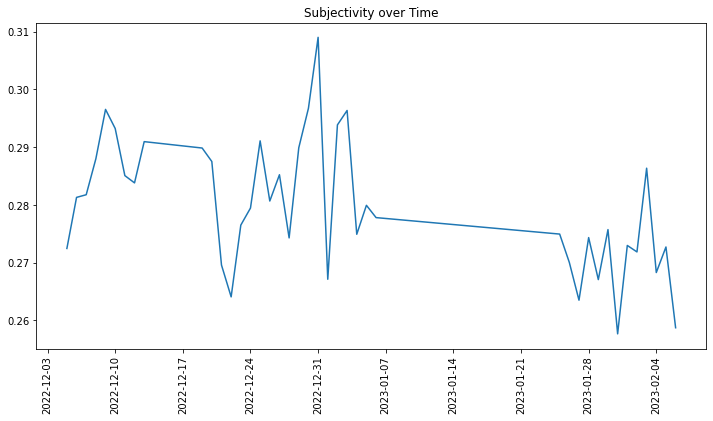

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(sub_grouped.index, sub_grouped['subjectivity'])
plt.xticks(rotation=90) 
plt.title('Subjectivity over Time')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.show()

In [19]:
pol_grouped = df.groupby('date').agg({'polarity': 'mean'}) 

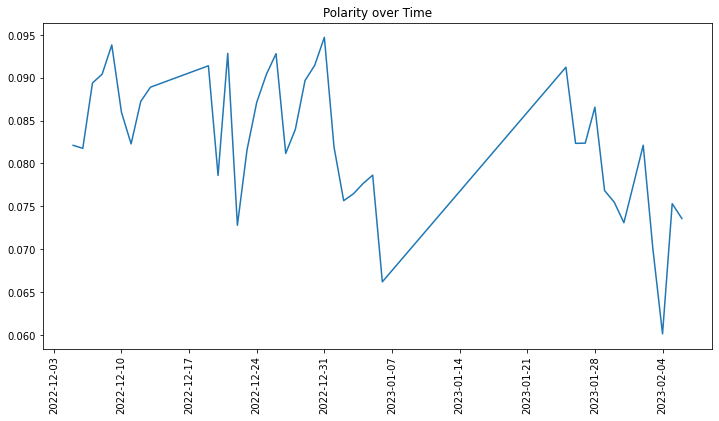

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(pol_grouped.index, pol_grouped['polarity'])
plt.xticks(rotation=90) 
plt.title('Polarity over Time')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.show()

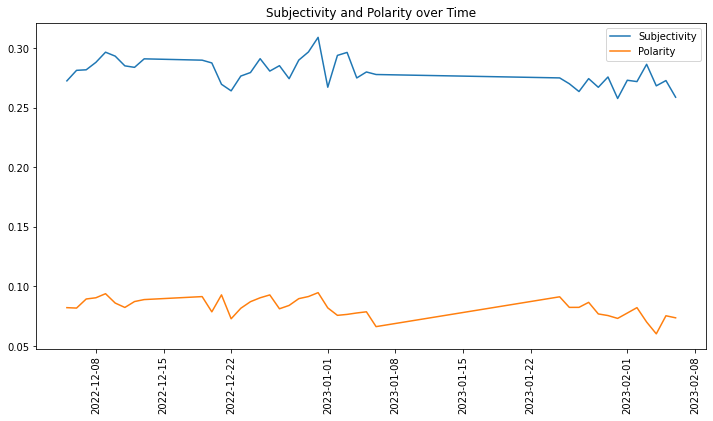

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(sub_grouped.index, sub_grouped['subjectivity'], label='Subjectivity')
plt.plot(pol_grouped.index, pol_grouped['polarity'], label='Polarity')
plt.xticks(rotation=90)
plt.title('Subjectivity and Polarity over Time')
plt.legend()
plt.show()

##Comparing Vader and TextBlob regarding the polarity

In [22]:
sid = SentimentIntensityAnalyzer()

df['vader_polarity'] = df['clean_text'].map(
    lambda text: sid.polarity_scores(text)['compound'])     

In [23]:
polarity_df = df[['polarity', 'vader_polarity']]
polarity_df

polarity  vader_polarity
0           0.00         -0.4939
1          -0.05          0.0000
2           0.00          0.0000
3           0.00          0.0000
4           0.00          0.0000
...          ...             ...
127881      0.00          0.0000
127882      0.00          0.0000
127883      0.00          0.0000
127884      0.00          0.0000
127885      0.00          0.0000

[127886 rows x 2 columns]

In [24]:
polarity_df = polarity_df.rename(columns={'polarity': 'TextBlob',
                                          'vader_polarity': 'Vader'})

fig = px.histogram(polarity_df, x=['Vader', 'TextBlob'], nbins=40, barmode='group',
                   color_discrete_sequence=['#1DA1F2', '#EB8C17'])
fig.update_layout(title='Comparison of the distributions of sentimental polarities',
                  xaxis_title='Polarity', yaxis_title='Count')
fig.show()

=> this graph allows us to see that although Vader and TextBlob use a similar method, the results are not exactly the same. <br>
=> there is a slight shift on the positive side of the polarity.

In [25]:
polarity_df.describe()

TextBlob          Vader
count  127886.000000  127886.000000
mean        0.081516       0.161816
std         0.256053       0.365462
min        -1.000000      -0.995900
25%         0.000000       0.000000
50%         0.000000       0.000000
75%         0.166667       0.440400
max         1.000000       0.989100

## Using nltk.sentiment.vader for Sentiment Analysis

In [26]:
sia = SentimentIntensityAnalyzer()

In [27]:
def vader_sentiment_result(sent):
    scores = sia.polarity_scores(sent)
    if scores['compound'] > 0.05:
      return 1
    elif scores['compound'] < -0.05:
      return -1
    else:
      return 0

In [28]:
df["sentiment_vader"] = df["clean_text"].apply(lambda x: vader_sentiment_result(x))

In [29]:
df.head(5)

clean_text        clean_hashtags  \
0  chatgpt realli chang shake inform communic sec...               chatgpt   
1   chatgpt anoth woje leftist tool noth  tcosvbxpma  chatgpt woje leftist   
2  unleash entrepreneuri potenti  chatgpt power b...          chatgpt busi   
3  chat golgappa papri tikki indian twist thing c...               chatgpt   
4  ai expert made comment bc ckin idea talk fact ...                  fact   

         date emojis  subjectivity  polarity  vader_polarity  sentiment_vader  
0  2023-02-06                  0.0      0.00         -0.4939               -1  
1  2023-02-06                  0.6     -0.05          0.0000                0  
2  2023-02-06                  0.0      0.00          0.0000                0  
3  2023-02-06                  0.0      0.00          0.0000                0  
4  2023-02-06                  0.0      0.00          0.0000                0

In [30]:
# mapping the numbers from vader to words
label_map = {1: 'positive', 0: 'neutral', -1: 'negative'}
df['sentiment'] = df['sentiment_vader'].map(label_map)

In [31]:
df.head(5)

clean_text        clean_hashtags  \
0  chatgpt realli chang shake inform communic sec...               chatgpt   
1   chatgpt anoth woje leftist tool noth  tcosvbxpma  chatgpt woje leftist   
2  unleash entrepreneuri potenti  chatgpt power b...          chatgpt busi   
3  chat golgappa papri tikki indian twist thing c...               chatgpt   
4  ai expert made comment bc ckin idea talk fact ...                  fact   

         date emojis  subjectivity  polarity  vader_polarity  sentiment_vader  \
0  2023-02-06                  0.0      0.00         -0.4939               -1   
1  2023-02-06                  0.6     -0.05          0.0000                0   
2  2023-02-06                  0.0      0.00          0.0000                0   
3  2023-02-06                  0.0      0.00          0.0000                0   
4  2023-02-06                  0.0      0.00          0.0000                0   

  sentiment  
0  negative  
1   neutral  
2   neutral  
3   neutral  
4   neutral

In [32]:
counts = df['sentiment'].value_counts()

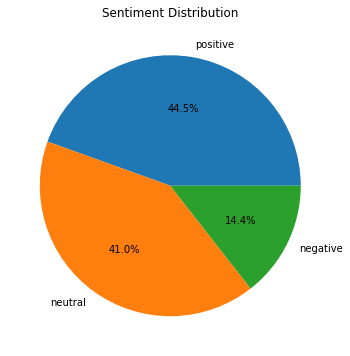

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
counts.plot(kind='pie', autopct='%1.1f%%', labels=counts.index)
plt.title('Sentiment Distribution')
plt.ylabel("");

=> 

###Looking at the sentiment over time

In [34]:
sentiment_grouped = df.groupby('date').agg({'sentiment_vader': 'mean'}) 

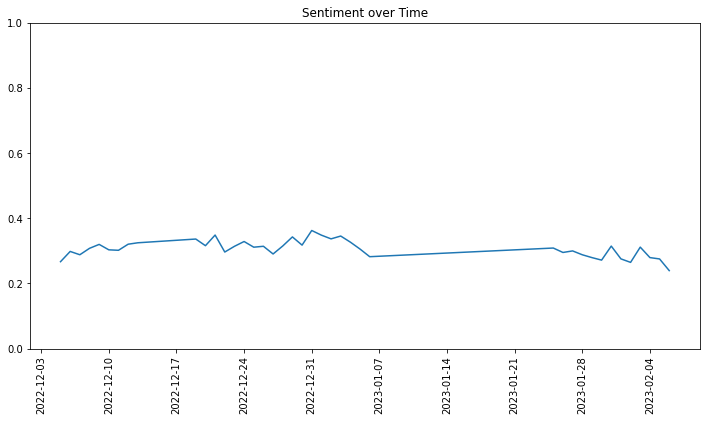

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(sentiment_grouped.index, sentiment_grouped['sentiment_vader'])
plt.xticks(rotation=90) 
plt.title('Sentiment over Time')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_ylim([0, 1])
plt.show()

=>

##Analysing the Emojis in the Tweets

In [36]:
emojis = df['emojis']
emojis

0            
1            
2            
3            
4            
         ... 
127881    🙏🙏🙏
127882       
127883       
127884       
127885       
Name: emojis, Length: 127886, dtype: object

In [35]:
emojis.replace('', np.nan, inplace=True)

In [36]:
emojis.isnull().sum()

110663

In [37]:
emojis.dropna(inplace=True)
emojis.reset_index(drop=True, inplace=True)

In [38]:
emojis.isnull().sum()

0

In [39]:
emojis.head()

0    🐋🐳🐋🐳👀
1        🔴
2        😁
3        😏
4        👉
Name: emojis, dtype: object

In [40]:
emojis = emojis.str.split('')
emojis = emojis.explode()

In [41]:
emojis.replace('', np.nan, inplace=True)
emojis.isnull().sum()

34446

In [42]:
emojis.dropna(inplace=True)
emojis.reset_index(drop=True, inplace=True)
emojis

0        🐋
1        🐳
2        🐋
3        🐳
4        👀
        ..
30614    😁
30615    😅
30616    🙏
30617    🙏
30618    🙏
Name: emojis, Length: 30619, dtype: object

In [43]:
# getting the most frequently used emoji
most_common_emoji = emojis.value_counts().index[0]
print('The most frequently used emoji is:', most_common_emoji)

The most frequently used emoji is: 😂


In [44]:
emoji_counts = emojis.value_counts()
emoji_counts.head(10)

😂    2404
👇    2388
🔥    1461
👉    1118
🚀    1082
👀     868
😅     790
🏻     541
😎     482
😉     443
Name: emojis, dtype: int64

In [45]:
# extracting the 10 most used emojis
top_10_emojis = emojis.value_counts().nlargest(10)
emoji_df = pd.DataFrame(top_10_emojis)

In [46]:
fig = px.bar(emoji_df, x=emoji_df.index, y='emojis', text='emojis')

fig.update_layout(title='The 10 most used emojis in the tweets')
fig.update_xaxes(title='')
fig.update_yaxes(title='')
fig.update_yaxes(tickvals=[])

fig.show()

##NCLERX

In [37]:
def emotion(x):
    text = NRCLex(x)
    if text.top_emotions[0][1] == 0.0:
        return "No emotion"
    else:
        return text.top_emotions[0][0]

In [38]:
df['Emotion'] = df['clean_text'].apply(emotion)
df.head()

clean_text        clean_hashtags  \
0  chatgpt realli chang shake inform communic sec...               chatgpt   
1   chatgpt anoth woje leftist tool noth  tcosvbxpma  chatgpt woje leftist   
2  unleash entrepreneuri potenti  chatgpt power b...          chatgpt busi   
3  chat golgappa papri tikki indian twist thing c...               chatgpt   
4  ai expert made comment bc ckin idea talk fact ...                  fact   

         date emojis  subjectivity  polarity  vader_polarity  sentiment_vader  \
0  2023-02-06                  0.0      0.00         -0.4939               -1   
1  2023-02-06                  0.6     -0.05          0.0000                0   
2  2023-02-06                  0.0      0.00          0.0000                0   
3  2023-02-06                  0.0      0.00          0.0000                0   
4  2023-02-06                  0.0      0.00          0.0000                0   

  sentiment       Emotion  
0  negative      negative  
1   neutral    No emotion  
2   neutral  anticipation  
3   neutral    No emotion  
4   neutral         trust

In [39]:
df['Emotion'].value_counts()

positive        39496
No emotion      32950
trust           24075
fear            10466
negative         7372
anticipation     7039
anger            3489
surprise         2653
sadness           192
joy                90
disgust            64
Name: Emotion, dtype: int64

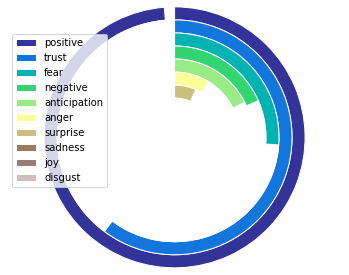

In [40]:
df_chart = df[df.Emotion != "No emotion"]
labels = df_chart.Emotion.value_counts().index.tolist()
data = df_chart.Emotion.value_counts()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

<ipython-input-41-4b01fd6b6427>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



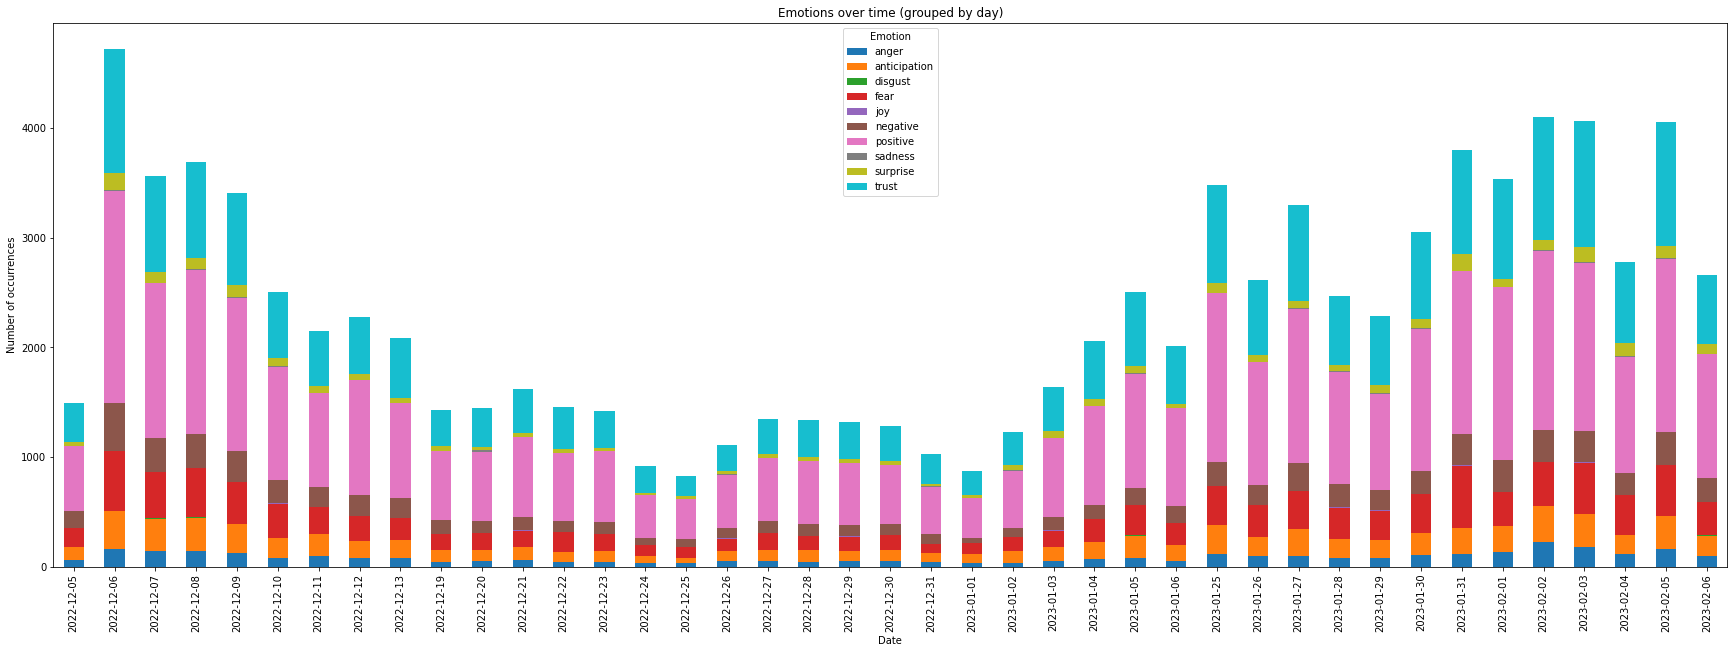

In [41]:
# Filter out 'No emotion' values
df_filtered = df[df['Emotion'] != 'No emotion']

# Convert the date column to a datetime type if necessary
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by day and count number of occurrences for each emotion
df_grouped = df_filtered.groupby([df_filtered['date'].dt.date, 'Emotion']).size().unstack().fillna(0)

# Plot the stacked bar chart
ax = df_grouped.plot(kind='bar', stacked=True, figsize=(30,10))

# Set the title and labels
ax.set_title("Emotions over time (grouped by day)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of occurrences")

# Show the plot
plt.show()

In [43]:
import plotly.express as px

# Filter out 'No emotion' values
df_filtered = df[df['Emotion'] != 'No emotion']

# Convert the date column to a datetime type if necessary
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
#'df_filtered['date'] = df_filtered['date'].astype(str)

# Group by day and count number of occurrences for each emotion
df_grouped = df_filtered.groupby([df_filtered['date'].dt.date, 'Emotion']).size().unstack().fillna(0)

# Create the stacked bar chart
fig = px.bar(df_grouped, x=df_grouped.index, y=df_grouped.columns, barmode='stack')

# Set the title and labels
fig.update_layout(title="Emotions over time (grouped by day)", xaxis_title="Date", yaxis_title="Number of occurrences")

# Rotate x-axis tick labels
fig.update_layout(xaxis_tickangle=-90)

# Update x-axis tick labels to show only dates with data
new_tickvals = [date for date in df_grouped.index if any(df_grouped.loc[date])]
fig.update_xaxes(tickvals=new_tickvals)

fig.show()

<ipython-input-43-167c0256c7ac>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
import plotly.graph_objects as go

# Group by day and count number of occurrences for each emotion
df_grouped = df_filtered.groupby([df_filtered['date'].dt.date, 'Emotion']).size().unstack().fillna(0)

# Create a line chart figure
fig = go.Figure()

# Add a line trace for each emotion
for col in df_grouped.columns:
    fig.add_trace(go.Scatter(x=df_grouped.index, y=df_grouped[col], mode='lines', name=col))

# Set the title and labels
fig.update_layout(title="Emotions over time (grouped by day)", xaxis_title="", yaxis_title="Number of occurrences", xaxis_tickangle=-90)
fig.update_xaxes(tickvals=df_grouped.index[::2])

# Show the plot
fig.show()

##Roberta Approach

In [ ]:
sia = SentimentIntensityAnalyzer()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
print(device)

cuda


In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)

In [ ]:
def softmax(x):
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum()

In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt').to(device)
    output = model(**encoded_text)
    scores = output[0][0]
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0].item(),
        'roberta_neu' : scores[1].item(),
        'roberta_pos' : scores[2].item()
    }
    return scores_dict

In [ ]:
# add an id column to enumerate the rows
df['id'] = df.reset_index().index + 1

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['clean_text']
        myid = row['id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/127886 [00:00<?, ?it/s]

In [ ]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = df.merge(results_df, how='left')

In [ ]:
results_df

clean_text  \
0       chatgpt realli chang shake inform communic sec...   
1        chatgpt anoth woje leftist tool noth  tcosvbxpma   
2       unleash entrepreneuri potenti  chatgpt power b...   
3       chat golgappa papri tikki indian twist thing c...   
4       ai expert made comment bc ckin idea talk fact ...   
...                                                   ...   
127881                                                      
127882                                                      
127883                                                      
127884                                                      
127885                                                      

              clean_hashtags        date emojis  subjectivity  polarity  \
0                    chatgpt  2023-02-06    NaN           0.0      0.00   
1       chatgpt woje leftist  2023-02-06    NaN           0.6     -0.05   
2               chatgpt busi  2023-02-06    NaN           0.0      0.00   
3                    chatgpt  2023-02-06    NaN           0.0      0.00   
4                       fact  2023-02-06    NaN           0.0      0.00   
...                      ...         ...    ...           ...       ...   
127881                        2022-12-05    🙏🙏🙏           0.0      0.00   
127882                        2022-12-05    NaN           0.0      0.00   
127883                        2022-12-05    NaN           0.0      0.00   
127884                        2022-12-05    NaN           0.0      0.00   
127885                        2022-12-05    NaN           0.0      0.00   

        vader_polarity  sentiment_vader sentiment       Emotion      id  \
0              -0.4939               -1  negative      negative       1   
1               0.0000                0   neutral    No emotion       2   
2               0.0000                0   neutral  anticipation       3   
3               0.0000                0   neutral    No emotion       4   
4               0.0000                0   neutral         trust       5   
...                ...              ...       ...           ...     ...   
127881          0.0000                0   neutral    No emotion  127882   
127882          0.0000                0   neutral    No emotion  127883   
127883          0.0000                0   neutral    No emotion  127884   
127884          0.0000                0   neutral    No emotion  127885   
127885          0.0000                0   neutral    No emotion  127886   

        vader_neg  vader_neu  vader_pos  vader_compound  roberta_neg  \
0           0.282      0.644      0.074         -0.4939     0.098003   
1           0.000      1.000      0.000          0.0000     0.248928   
2           0.000      1.000      0.000          0.0000     0.115962   
3           0.000      1.000      0.000          0.0000     0.082326   
4           0.000      1.000      0.000          0.0000     0.071527   
...           ...        ...        ...             ...          ...   
127881      0.000      0.000      0.000          0.0000     0.258294   
127882      0.000      0.000      0.000          0.0000     0.258294   
127883      0.000      0.000      0.000          0.0000     0.258294   
127884      0.000      0.000      0.000          0.0000     0.258294   
127885      0.000      0.000      0.000          0.0000     0.258294   

        roberta_neu  roberta_pos  
0          0.833265     0.068733  
1          0.713522     0.037549  
2          0.833322     0.050717  
3          0.869242     0.048432  
4          0.852720     0.075753  
...             ...          ...  
127881     0.451272     0.290433  
127882     0.451272     0.290433  
127883     0.451272     0.290433  
127884     0.451272     0.290433  
127885     0.451272     0.290433  

[127886 rows x 18 columns]

In [ ]:
results_df['roberta_neg'] = pd.to_numeric(results_df['roberta_neg'])
results_df['roberta_neu'] = pd.to_numeric(results_df['roberta_neu'])
results_df['roberta_pos'] = pd.to_numeric(results_df['roberta_pos'])

In [ ]:
column_to_word = {'roberta_neg': 'negative', 'roberta_neu': 'neutral', 'roberta_pos': 'positive'}

In [ ]:
results_df['roberta_sentiment'] = results_df[['roberta_neg', 'roberta_neu', 'roberta_pos']].idxmax(axis=1).map(column_to_word)

In [ ]:
roberta_count = results_df['roberta_sentiment'].value_counts()

In [ ]:
results_df['vader_neg'] = pd.to_numeric(results_df['vader_neg'])
results_df['vader_neu'] = pd.to_numeric(results_df['vader_neu'])
results_df['vader_pos'] = pd.to_numeric(results_df['vader_pos'])
results_df['vader_compound'] = pd.to_numeric(results_df['vader_compound'])

In [ ]:
results_df['vader_sentiment'] = results_df['vader_compound'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

In [ ]:
vader_count = results_df['vader_sentiment'].value_counts()

In [ ]:
results_df.to_csv('/content/drive/MyDrive/NLP/roberta_vader.csv')

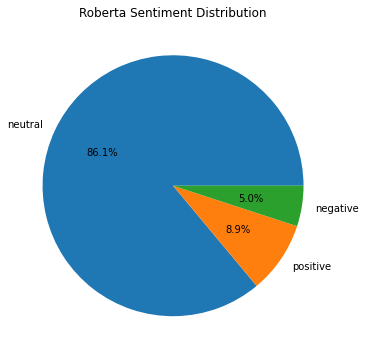

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
roberta_count.plot(kind='pie', autopct='%1.1f%%', labels=roberta_count.index)
plt.title('Roberta Sentiment Distribution')
plt.ylabel("");

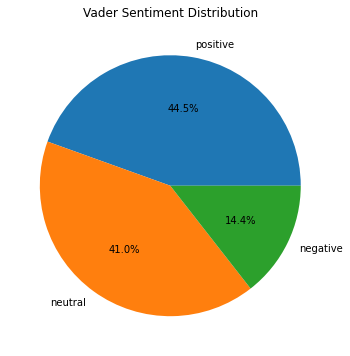

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
vader_count.plot(kind='pie', autopct='%1.1f%%', labels=vader_count.index)
plt.title('Vader Sentiment Distribution')
plt.ylabel("");

In [49]:
with open('/content/drive/MyDrive/NLP/roberta_vader.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

df = pd.DataFrame(data, columns=header)

In [50]:
sentiment_df = df[['roberta_sentiment', 'vader_sentiment']]

In [51]:
sentiment_df = sentiment_df.rename(columns={'roberta_sentiment': 'Roberta',
                                          'vader_sentiment': 'Vader'})

fig = px.histogram(sentiment_df, x=[sentiment_df['Vader'], sentiment_df['Roberta']], nbins=3, barmode='group',
                   color_discrete_sequence=['#3c7db6', '#aa3b87'])
fig.update_layout(title='Comparison of Roberta and Vader regarding the sentiment distribution',
                  xaxis_title='Sentiment Class', yaxis_title='Count')
fig.show()

## Zero Shot Classification Approach

### Using Hugging Face Zero Shot Classifier

The zero-shot-classification (ZSC) model from Hugging Face is a powerful and flexible tool for text classification tasks. It allows you to classify text into any number of categories, without the need to train a model specifically on those categories.

The performance of the ZSC model can vary depending on a number of factors, including the quality of the input data, the complexity of the classification task, and the choice of candidate labels. In general, the ZSC model can achieve high levels of accuracy on many text classification tasks, but may struggle with more nuanced or complex tasks, such as detecting sarcasm or irony.

One advantage of the ZSC model is its flexibility and ease of use. It allows you to quickly and easily classify text data using a pre-trained model, without needing to spend time and resources on model training and optimization. Additionally, the ZSC model can be fine-tuned on specific datasets to improve its performance on specific tasks, if necessary.

Overall, the ZSC model is a powerful and useful tool for many text classification tasks, but its performance will depend on the specific use case and the quality of the input data. It's always a good idea to evaluate the performance of any machine learning model on your specific use case, and to consider the limitations and potential biases of the model.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
with open('/content/drive/MyDrive/NLP/roberta_vader.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

df = pd.DataFrame(data, columns=header)

In [ ]:
# Load the tokenizer and zero-shot classification model
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-mnli")
model = AutoModelForSequenceClassification.from_pretrained("facebook/bart-large-mnli")

# Move the PyTorch model to the GPU
model = model

classifier = pipeline("zero-shot-classification", model=model, tokenizer=tokenizer)

In [ ]:
positives = df[df['roberta_sentiment'] == "positive"]
negatives = df[df['roberta_sentiment'] == "negative"]

In [ ]:
positives.shape

(11408, 21)

In [ ]:
negatives.shape

(6415, 21)

In [ ]:
positives = positives.sort_values(by=['roberta_pos'], ascending=False)

In [ ]:
positives = positives[:200]

In [ ]:
group_labels = ["education", "art", "technology", "business"]
pos_text = positives['clean_text'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_pos = classifier(pos_text, group_labels)

In [ ]:
negatives = negatives.sort_values(by=['roberta_neg'], ascending=False)

In [ ]:
negatives = negatives[:100]

In [ ]:
group_labels = ["education", "art", "technology", "business"]
neg_text = negatives['clean_text'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_neg = classifier(neg_text, group_labels)

In [ ]:
df_pos = pd.DataFrame.from_records(results_pos)

In [ ]:
df_pos

sequence  \
0    best day ever ca nt wait see tomorrow bring bl...   
1    chatgpt second best thing ever happen first bl...   
2             love googl chatgpt make life much easier   
3    neymrqz cool santiago neymrqz love whole conce...   
4    love sarahcandersen enjoy nytim gift also ai c...   
..                                                 ...   
195   tcoomdyrxji worth chatgpt markdic made whole ...   
196  tri chatgpt day ago great useful powerful tool...   
197  great post partner nadav ai slowli take enjoy ...   
198              hype much enjoy chatgpt  tcogvqrbnbyb   
199  drlancast great spot bbc thoma good job good w...   

                                     labels  \
0    [art, technology, education, business]   
1    [technology, art, education, business]   
2    [technology, education, art, business]   
3    [technology, art, business, education]   
4    [technology, art, education, business]   
..                                      ...   
195  [technology, business, art, education]   
196  [technology, business, art, education]   
197  [technology, business, art, education]   
198  [technology, education, art, business]   
199  [technology, business, education, art]   

                                                scores  
0    [0.3898658752441406, 0.35714659094810486, 0.16...  
1    [0.3656197488307953, 0.31092551350593567, 0.25...  
2    [0.9685792326927185, 0.012740585021674633, 0.0...  
3    [0.7176588177680969, 0.1900755912065506, 0.059...  
4    [0.3313290774822235, 0.30013278126716614, 0.26...  
..                                                 ...  
195  [0.6221205592155457, 0.17892925441265106, 0.15...  
196  [0.951185941696167, 0.017907055094838142, 0.01...  
197  [0.5961633920669556, 0.1562657356262207, 0.156...  
198  [0.8507161140441895, 0.06010539457201958, 0.05...  
199  [0.9746577143669128, 0.013328002765774727, 0.0...  

[200 rows x 3 columns]

In [ ]:
df_pos['topic'] = df_pos['labels'].apply(lambda x: x[0])

In [ ]:
df_neg = pd.DataFrame.from_records(results_neg)

In [ ]:
df_neg['topic'] = df_neg['labels'].apply(lambda x: x[0])

In [ ]:
df_neg

sequence  \
0   still hate fuck narc edward tian chatgpt fed n...   
1   still hate fuck narc edward tian chatgpt fed n...   
2   openai issa fuck god game fuck changer chatgpt...   
3   man hate ai artwork pretti trash chatgpt feel ...   
4           hate stupid fuck ai chatgpt  tconeqjobxod   
..                                                ...   
95  one worst part everi quip everi zinger banger ...   
96                     damnnn fck chatgpt  tcoqxrsusp   
97               chatgpt yep thing suck  tcofrygvkmsk   
98  nt understand peopl exit chatgpt liter scaries...   
99  chatgpt program woke useless worthless end yea...   

                                    labels  \
0   [technology, business, education, art]   
1   [technology, business, education, art]   
2   [technology, business, art, education]   
3   [art, education, technology, business]   
4   [technology, business, education, art]   
..                                     ...   
95  [technology, business, education, art]   
96  [technology, business, education, art]   
97  [technology, business, education, art]   
98  [technology, education, business, art]   
99  [technology, business, education, art]   

                                               scores       topic  
0   [0.4385235905647278, 0.32365578413009644, 0.14...  technology  
1   [0.4385235905647278, 0.32365578413009644, 0.14...  technology  
2   [0.9276578426361084, 0.04961491748690605, 0.01...  technology  
3   [0.8847076296806335, 0.0647926926612854, 0.034...         art  
4   [0.9005359411239624, 0.05066126212477684, 0.03...  technology  
..                                                ...         ...  
95  [0.5072101950645447, 0.27055662870407104, 0.14...  technology  
96  [0.9108128547668457, 0.04276056960225105, 0.03...  technology  
97  [0.6325311660766602, 0.2412496656179428, 0.102...  technology  
98  [0.4702218770980835, 0.23825900256633759, 0.22...  technology  
99  [0.9423274993896484, 0.029032234102487564, 0.0...  technology  

[100 rows x 4 columns]

In [ ]:
df_pos_art = df_pos[df_pos['topic'] == "art"]
df_pos_tech = df_pos[df_pos['topic'] == "technology"]
df_pos_ed = df_pos[df_pos['topic'] == "education"]
df_pos_bus = df_pos[df_pos['topic'] == "business"]

In [ ]:
df_neg_art = df_neg[df_neg['topic'] == "art"]
df_neg_tech = df_neg[df_neg['topic'] == "technology"]
df_neg_ed = df_neg[df_neg['topic'] == "education"]
df_neg_bus = df_neg[df_neg['topic'] == "business"]

In [ ]:
pos_sent_labels = ["excited", "curious", "convinced"]

In [ ]:
df_pos_art = df_pos_art['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_pos0 = classifier(df_pos_art, pos_sent_labels)

In [ ]:
df_pos_tech = df_pos_tech['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_pos1 = classifier(df_pos_tech, pos_sent_labels)

In [ ]:
df_pos_ed = df_pos_ed['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_pos2 = classifier(df_pos_ed, pos_sent_labels)

In [ ]:
df_pos_bus = df_pos_bus['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_pos3 = classifier(df_pos_bus, pos_sent_labels)

In [ ]:
df_pos_art = pd.DataFrame.from_records(results_pos0)
df_pos_tech = pd.DataFrame.from_records(results_pos1)
df_pos_ed = pd.DataFrame.from_records(results_pos2)
df_pos_bus = pd.DataFrame.from_records(results_pos3)

In [ ]:
df_pos.to_csv('/content/drive/MyDrive/NLP/positives.csv')

In [ ]:
df_neg.to_csv('/content/drive/MyDrive/NLP/negatives.csv')

In [ ]:
neg_sent_labels = ["critical", "afraid", "rejecting"]

In [ ]:
df_neg_art = df_neg_art['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_neg0 = classifier(df_neg_art, neg_sent_labels)

In [ ]:
df_neg_tech = df_neg_tech['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_neg1 = classifier(df_neg_tech, neg_sent_labels)

In [ ]:
df_neg_ed = df_neg_ed['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_neg2 = classifier(df_neg_ed, neg_sent_labels)

In [ ]:
df_neg_bus = df_neg_bus['sequence'].tolist()

# Perform zero-shot classification and move the resulting tensor to the GPU
results_neg3 = classifier(df_neg_bus, neg_sent_labels)

In [ ]:
df_neg_art = pd.DataFrame.from_records(results_neg0)
df_neg_tech = pd.DataFrame.from_records(results_neg1)
df_neg_ed = pd.DataFrame.from_records(results_neg2)
df_neg_bus = pd.DataFrame.from_records(results_neg3)

In [ ]:
df_pos_art['sentiment'] = df_pos_art['labels'].apply(lambda x: x[0])
df_pos_tech['sentiment'] = df_pos_tech['labels'].apply(lambda x: x[0])
df_pos_ed['sentiment'] = df_pos_ed['labels'].apply(lambda x: x[0])
df_pos_bus['sentiment'] = df_pos_bus['labels'].apply(lambda x: x[0])
df_neg_art['sentiment'] = df_neg_art['labels'].apply(lambda x: x[0])
df_neg_tech['sentiment'] = df_neg_tech['labels'].apply(lambda x: x[0])
df_neg_ed['sentiment'] = df_neg_ed['labels'].apply(lambda x: x[0])
df_neg_bus['sentiment'] = df_neg_bus['labels'].apply(lambda x: x[0])

In [ ]:
df_pos_art['topic'] = 'art'
df_pos_tech['topic'] = 'technology'
df_pos_ed['topic'] = 'education'
df_pos_bus['topic'] = 'business'
df_neg_art['topic'] = 'art'
df_neg_tech['topic'] = 'technology'
df_neg_ed['topic'] = 'education'
df_neg_bus['topic'] = 'business'

In [ ]:
topics_pos = pd.concat([df_pos_art, df_pos_tech, df_pos_ed, df_pos_bus])

In [ ]:
topics_pos = topics_pos.drop(['labels', 'scores'], axis=1)

In [ ]:
topics_neg = pd.concat([df_neg_art, df_neg_tech, df_neg_ed, df_neg_bus])

In [ ]:
topics_neg = topics_neg.drop(['labels', 'scores'], axis=1)

In [ ]:
topics_neg.to_csv('/content/drive/MyDrive/NLP/topics_neg.csv')
topics_pos.to_csv('/content/drive/MyDrive/NLP/topics_pos.csv')

In [52]:
with open('/content/drive/MyDrive/NLP/topics_neg.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

df_neg = pd.DataFrame(data, columns=header)

In [53]:
with open('/content/drive/MyDrive/NLP/topics_pos.csv', 'r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [row for row in reader]

df_pos = pd.DataFrame(data, columns=header)

##Visualizing the distribution of sentiment in the classified topics

In [86]:
# group the dataframe by topic and sentiment, and count the number of occurrences
grouped_df = df_pos.groupby(['topic', 'sentiment']).size().reset_index(name='count')

# create a grouped bar chart
fig = px.bar(grouped_df, x='topic', y='count', color='sentiment', barmode='group')

# set the chart title and axis labels
fig.update_layout(title='Positive Sentiment Distribution by Topic', xaxis_title='Topic', yaxis_title='Count')

# show the chart
fig.show()

In [87]:
# group the dataframe by topic and sentiment, and count the number of occurrences
grouped_df = df_neg.groupby(['topic', 'sentiment']).size().reset_index(name='count')

# create a grouped bar chart
fig = px.bar(grouped_df, x='topic', y='count', color='sentiment', barmode='group')

# set the chart title and axis labels
fig.update_layout(title='Negative Sentiment Distribution by Topic', xaxis_title='Topic', yaxis_title='Count')

# show the chart
fig.show()

**Result**: <br>
You can see that technology is the most represented topic in the sample, whether regarding the negative or positive tweets. 

In [111]:
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

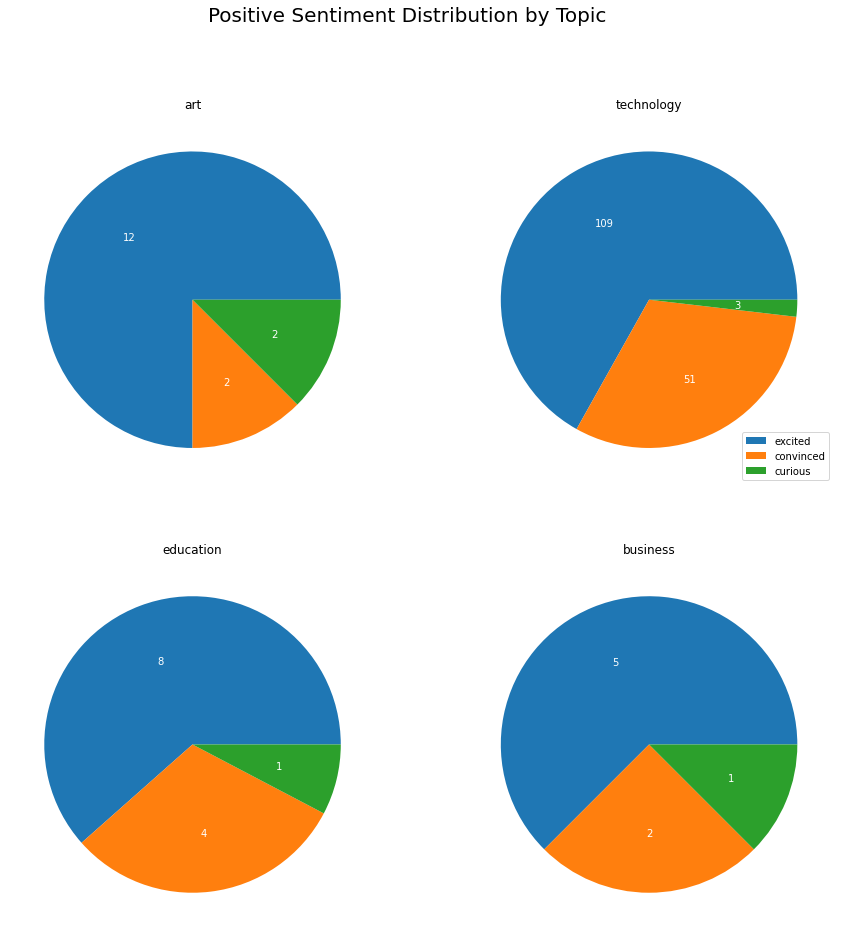

In [115]:
# divide the dataframe by topic
topics = df_pos['topic'].unique()
topic_dfs = [df_pos[df_pos['topic']==t] for t in topics]

# create a 2x2 subplot with pie charts
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# plot the sentiment distribution for each topic in a pie chart only using the columns 'sentiment'
for i, ax in enumerate(axs.flatten()):
    ax.pie(topic_dfs[i]['sentiment'].value_counts(), autopct=autopct_format(topic_dfs[i]['sentiment'].value_counts()), textprops={'color':"w"})
    ax.set_title(topics[i])
axs[0, 1].legend(topic_dfs[1]['sentiment'].unique(), loc='lower right')

# add a common title to the chart
fig.suptitle('Positive Sentiment Distribution by Topic', fontsize=20)

plt.show() 

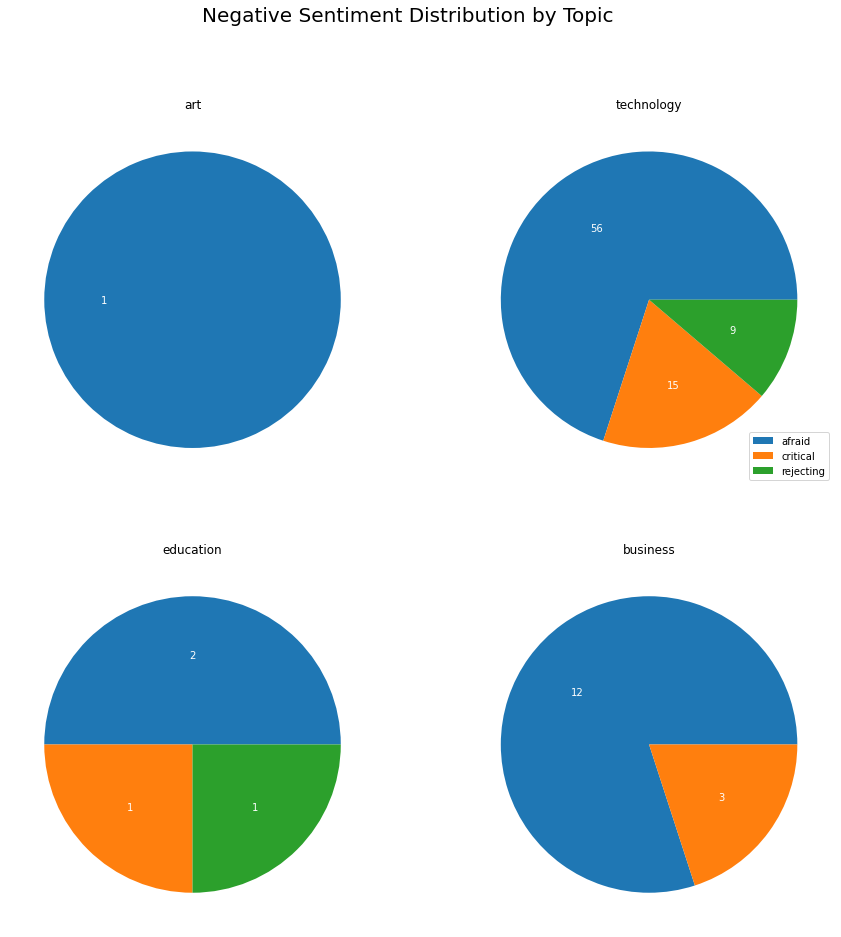

In [116]:
# divide the dataframe by topic
topics = df_neg['topic'].unique()
topic_dfs = [df_neg[df_neg['topic']==t] for t in topics]

# create a 2x2 subplot with pie charts
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# plot the sentiment distribution for each topic in a pie chart only using the columns 'sentiment'
for i, ax in enumerate(axs.flatten()):
    ax.pie(topic_dfs[i]['sentiment'].value_counts(), autopct=autopct_format(topic_dfs[i]['sentiment'].value_counts()), textprops={'color':"w"})
    ax.set_title(topics[i])
axs[0, 1].legend(topic_dfs[1]['sentiment'].unique(), loc='lower right')

# add a common title to the chart
fig.suptitle('Negative Sentiment Distribution by Topic', fontsize=20)

plt.show() 

**Result:**<br>
Looking at the distribution of the sentiment in each topic, you can see 